# 1. Import Packages


In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from catboost import CatBoostRegressor, Pool, metrics, cv
from sklearn.metrics import accuracy_score, mean_squared_error,r2_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPRegressor,MLPClassifier
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
import lightgbm as lgb
import seaborn as sns
import pickle
from sklearn.cluster import KMeans

import xgboost as xgb
from hyperopt import fmin, tpe, hp, STATUS_OK

# 2. Prepare Data

Load Data

In [2]:
df_train = pd.read_csv('../data/train.csv')
df_test = pd.read_csv('../data/test.csv')
df_train = df_train.fillna('ffill')
df_test = df_test.fillna('ffill')

Separate Labels and Features

In [6]:
# separate labels from features
full_training_label_cols = ['TotalTimeStopped_p20','TotalTimeStopped_p40','TotalTimeStopped_p50',
                       'TotalTimeStopped_p60','TotalTimeStopped_p80',
                       'TimeFromFirstStop_p20','TimeFromFirstStop_p40','TimeFromFirstStop_p50',
                       'TimeFromFirstStop_p60','TimeFromFirstStop_p80',
                       'DistanceToFirstStop_p20','DistanceToFirstStop_p40','DistanceToFirstStop_p50',
                       'DistanceToFirstStop_p60','DistanceToFirstStop_p80']

# relevant label columns used for kaggle challenge
rel_training_label_cols = ['TotalTimeStopped_p20','TotalTimeStopped_p50','TotalTimeStopped_p80',
                       'DistanceToFirstStop_p20','DistanceToFirstStop_p50','DistanceToFirstStop_p80']

# get label columns
df_train_y = df_train[rel_training_label_cols]

# get data by dropping columns not needed
df_test_X = df_test.drop(columns=['RowId'])
df_train_X = df_train.drop(columns=['RowId']+full_training_label_cols)

Separate Data by City

In [7]:
# train and testing dicts for cities
cities = ['Atlanta','Boston','Chicago','Philadelphia']
city_training_datasets_X = {}
city_training_datasets_y = {}
city_testing_datasets_X = {}

# training
for city in cities:
    # get rows for this city
    city_idxs = (df_train_X['City'] == city).values.nonzero()[0]

    # get X (data) and y (labels)
    city_training_datasets_X[city] = df_train_X.loc[city_idxs]
    city_training_datasets_y[city] = df_train_y.loc[city_idxs]

    # drop the city column from X (data)
    city_training_datasets_X[city] = city_training_datasets_X[city].drop(columns=['City'])

# testing
for city in cities:
    # get rows for this city
    city_idxs = (df_test_X['City'] == city).values.nonzero()[0]

    # get X (data)
    city_testing_datasets_X[city] = df_test_X.loc[city_idxs]

    # drop the city column from X (data)
    city_testing_datasets_X[city] = city_testing_datasets_X[city].drop(columns=['City'])

# 3. Feature Extraction

The intersection IDs act as a feature. Since we separate the data by city, we do not need to encode these and can directly use the ID.

Encode the entry and exit names since they give information on the street size

In [8]:
road_encoding = {
    'Road': 1,
    'Street': 2,
    'Avenue': 2,
    'Drive': 3,
    'Broad': 3,
    'Boulevard': 4
}

def encode(x):
    # for missing values encode with a zero
    if pd.isna(x):
        return 0
    for road in road_encoding.keys():
        if road in x:
            return road_encoding[road]
        
    return 0

for city in cities:
    # encode entry and exit for training
    city_training_datasets_X[city]['EntryTypeStreet'] = city_training_datasets_X[city]['EntryStreetName'].apply(encode)
    city_training_datasets_X[city]['ExitTypeStreet'] = city_training_datasets_X[city]['ExitStreetName'].apply(encode)
    
    # encode entry and exit for testing
    city_testing_datasets_X[city]['EntryTypeStreet'] = city_testing_datasets_X[city]['EntryStreetName'].apply(encode)
    city_testing_datasets_X[city]['ExitTypeStreet'] = city_testing_datasets_X[city]['ExitStreetName'].apply(encode)

Add a binary feature if the entry and exit street are the same

In [9]:
for city in cities:
    city_training_datasets_X[city]["entry_equals_exit"] = (city_training_datasets_X[city]["EntryStreetName"] == city_training_datasets_X[city]["ExitStreetName"]).astype(int)
    city_testing_datasets_X[city]["entry_equals_exit"] = (city_testing_datasets_X[city]["EntryStreetName"] ==  city_testing_datasets_X[city]["ExitStreetName"]).astype(int)

Add a numeric feature to encode the turn based on the entry and exit heading in a circular fashion.

In [10]:
directions = {
    'N': 0,
    'NE': 1/4,
    'E': 1/2,
    'SE': 3/4,
    'S': 1,
    'SW': 5/4,
    'W': 3/2,
    'NW': 7/4
}

for city in cities:
    city_training_datasets_X[city]['EntryHeading'] = city_training_datasets_X[city]['EntryHeading'].map(directions)
    city_training_datasets_X[city]['ExitHeading'] = city_training_datasets_X[city]['ExitHeading'].map(directions)

    city_testing_datasets_X[city]['EntryHeading'] = city_testing_datasets_X[city]['EntryHeading'].map(directions)
    city_testing_datasets_X[city]['ExitHeading'] = city_testing_datasets_X[city]['ExitHeading'].map(directions)

    city_training_datasets_X[city]['diffHeading'] = city_training_datasets_X[city]['EntryHeading']- city_training_datasets_X[city]['ExitHeading']  
    city_testing_datasets_X[city]['diffHeading'] = city_testing_datasets_X[city]['EntryHeading']- city_testing_datasets_X[city]['ExitHeading']

Add number of possible entries and exits per intersection

In [11]:
vectorized_len = np.vectorize(len)
for city in cities:
    num_entries = city_training_datasets_X[city].groupby('IntersectionId')['EntryStreetName'].unique()
    num_exits = city_training_datasets_X[city].groupby('IntersectionId')['ExitStreetName'].unique()
    ids = num_entries.index.values
    total = vectorized_len(num_entries.values) + vectorized_len(num_exits.values)
    new_col = dict(zip(num_entries.to_dict().keys(), total))
    city_training_datasets_X[city]['total_entries_exits'] = city_training_datasets_X[city]['IntersectionId'].map(new_col)

    num_entries = city_testing_datasets_X[city].groupby('IntersectionId')['EntryStreetName'].unique()
    num_exits = city_testing_datasets_X[city].groupby('IntersectionId')['ExitStreetName'].unique()
    total = vectorized_len(num_entries.values) + vectorized_len(num_exits.values)
    new_col = dict(zip(num_entries.to_dict().keys(), total))
    city_testing_datasets_X[city]['total_entries_exits'] = city_testing_datasets_X[city]['IntersectionId'].map(new_col)

Distance to City Center

In [12]:
def add_distance(df,city):
    
    df_center = pd.DataFrame({"Atlanta":[33.753746, -84.386330],
                             "Boston":[42.361145, -71.057083],
                             "Chicago":[41.881832, -87.623177],
                             "Philadelphia":[39.952583, -75.165222]})
    
    df["CenterDistance"] = df.apply(lambda row: np.sqrt((df_center[city][0] - row.Latitude) ** 2 +
                                                          (df_center[city][1] - row.Longitude) ** 2) , axis=1)
    df['CenterDistance'] = df['CenterDistance'].values.reshape(-1, 1)
    
for city in cities:
    add_distance(city_training_datasets_X[city],city)
    add_distance(city_testing_datasets_X[city],city)

Standardize the Longitude and Latitude

In [13]:
m_scaler = MinMaxScaler((-1,1))
s_scaler = StandardScaler()
for city in cities:
    # km_df = city_training_datasets_X[city][['Longitude','Latitude']].copy()
    # kmeans = KMeans(n_clusters=6, random_state=0, n_init="auto").fit(km_df)
    # dists = pd.DataFrame(s_scaler.fit_transform(kmeans.transform(km_df)),columns=['d1','d2','d3','d4','d5','d6']).reset_index(drop=True)
    # city_training_datasets_X[city] = pd.concat([city_training_datasets_X[city].reset_index(drop=True),dists],axis=1)

    # km_df = city_testing_datasets_X[city][['Longitude','Latitude']].copy()
    # kmeans = KMeans(n_clusters=6, random_state=0, n_init="auto").fit(km_df)
    # dists = pd.DataFrame(s_scaler.fit_transform(kmeans.transform(km_df)),columns=['d1','d2','d3','d4','d5','d6']).reset_index(drop=True)
    # city_testing_datasets_X[city] = pd.concat([city_testing_datasets_X[city].reset_index(drop=True),dists],axis=1)

    city_training_datasets_X[city]['Latitude'] = (m_scaler.fit_transform(city_training_datasets_X[city]['Latitude'].values.reshape(-1, 1)))
    city_training_datasets_X[city]['Longitude'] = (m_scaler.fit_transform(city_training_datasets_X[city]['Longitude'].values.reshape(-1, 1)))
    city_testing_datasets_X[city]['Latitude'] = (m_scaler.fit_transform(city_testing_datasets_X[city]['Latitude'].values.reshape(-1, 1)))
    city_testing_datasets_X[city]['Longitude'] = (m_scaler.fit_transform(city_testing_datasets_X[city]['Longitude'].values.reshape(-1, 1)))

Finally, drop the columns we don't need

In [14]:
for city in cities:
    city_training_datasets_X[city].drop(['EntryStreetName', 'ExitStreetName', 'Path'], axis=1, inplace=True)
    city_testing_datasets_X[city].drop(['EntryStreetName', 'ExitStreetName', 'Path'], axis=1, inplace=True)

Set the data types per column

In [15]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

for city in cities:
    city_training_datasets_X[city] = reduce_mem_usage(city_training_datasets_X[city])
    city_testing_datasets_X[city] = reduce_mem_usage(city_testing_datasets_X[city])

Memory usage of dataframe is 17.91 MB
Memory usage after optimization is: 4.33 MB
Decreased by 75.8%
Memory usage of dataframe is 39.48 MB
Memory usage after optimization is: 9.54 MB
Decreased by 75.8%
Memory usage of dataframe is 20.44 MB
Memory usage after optimization is: 4.94 MB
Decreased by 75.8%
Memory usage of dataframe is 46.44 MB
Memory usage after optimization is: 11.22 MB
Decreased by 75.8%
Memory usage of dataframe is 15.00 MB
Memory usage after optimization is: 3.62 MB
Decreased by 75.8%
Memory usage of dataframe is 33.82 MB
Memory usage after optimization is: 8.17 MB
Decreased by 75.8%
Memory usage of dataframe is 44.66 MB
Memory usage after optimization is: 10.79 MB
Decreased by 75.8%
Memory usage of dataframe is 100.02 MB
Memory usage after optimization is: 24.17 MB
Decreased by 75.8%


Finally, save the data to disk

In [16]:
with open('../data/basic_training_X.pickle', 'wb') as handle:
    pickle.dump(city_training_datasets_X, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('../data/basic_training_y.pickle', 'wb') as handle:
    pickle.dump(city_training_datasets_y, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('../data/basic_testing_X.pickle', 'wb') as handle:
    pickle.dump(city_testing_datasets_X, handle, protocol=pickle.HIGHEST_PROTOCOL)

# 4. Train Models

Load the data

In [3]:
cities = ['Atlanta','Boston','Chicago','Philadelphia']

with open('../data/basic_training_X.pickle', 'rb') as handle:
    city_training_datasets_X = pickle.load(handle)

with open('../data/basic_training_y.pickle', 'rb') as handle:
    city_training_datasets_y = pickle.load(handle)

with open('../data/basic_testing_X.pickle', 'rb') as handle:
    city_testing_datasets_X = pickle.load(handle)
# ----
with open('../data/gmaps_training_X.pickle', 'rb') as handle:
    g_city_training_datasets_X = pickle.load(handle)

with open('../data/gmaps_testing_X.pickle', 'rb') as handle:
    g_city_testing_datasets_X = pickle.load(handle)

gmaps_feats = ['elevation','cent_dist','num_places_50']
for city in cities:
    for feat in gmaps_feats:
        city_training_datasets_X[city][feat] = g_city_training_datasets_X[city][feat]
        city_testing_datasets_X[city][feat] = g_city_testing_datasets_X[city][feat]
    city_training_datasets_X[city] = city_training_datasets_X[city].rename(columns={'CenterDistance': 'CentDistL2', 'cent_dist': 'CentDist_gmap'})
    city_testing_datasets_X[city] = city_testing_datasets_X[city].rename(columns={'CenterDistance': 'CentDistL2', 'cent_dist': 'CentDist_gmap'})

In [14]:
g_city_testing_datasets_X.keys()

dict_keys(['Atlanta', 'Boston', 'Chicago', 'Philadelphia'])

In [13]:
g_city_testing_datasets_X['Atlanta']

,IntersectionId,Latitude_x,Longitude_x,EntryStreetName,ExitStreetName,EntryHeading,ExitHeading,Hour,Weekend,Month,Path,Latitude_y,Longitude_y,elevation,cent_dist,num_places_50
0,1,33.750940,-84.393032,Peachtree Street Southwest,Mitchell Street Southwest,SW,SE,0,0,6,Peachtree Street Southwest_SW_Mitchell Street ...,33.750940,-84.393032,317.481384,1000.0,20.0
1,1,33.750940,-84.393032,Peachtree Street Southwest,Peachtree Street Southwest,SW,SW,0,0,6,Peachtree Street Southwest_SW_Peachtree Street...,33.750940,-84.393032,317.481384,1000.0,20.0
2,1,33.750940,-84.393032,Peachtree Street Southwest,Peachtree Street Southwest,NE,NE,1,0,6,Peachtree Street Southwest_NE_Peachtree Street...,33.750940,-84.393032,317.481384,1000.0,20.0
3,1,33.750940,-84.393032,Peachtree Street Southwest,Peachtree Street Southwest,SW,SW,1,0,6,Peachtree Street Southwest_SW_Peachtree Street...,33.750940,-84.393032,317.481384,1000.0,20.0
4,1,33.750940,-84.393032,Peachtree Street Southwest,Peachtree Street Southwest,NE,NE,2,0,6,Peachtree Street Southwest_NE_Peachtree Street...,33.750940,-84.393032,317.481384,1000.0,20.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
344968,520,33.757096,-84.382228,Piedmont Avenue Northeast,Piedmont Avenue Northeast,N,N,16,1,12,Piedmont Avenue Northeast_N_Piedmont Avenue No...,33.757096,-84.382228,304.070526,704.0,15.0
344969,520,33.757096,-84.382228,Piedmont Avenue Northeast,Piedmont Avenue Northeast,N,N,17,1,12,Piedmont Avenue Northeast_N_Piedmont Avenue No...,33.757096,-84.382228,304.070526,704.0,15.0
344970,520,33.757096,-84.382228,Piedmont Avenue Northeast,Piedmont Avenue Northeast,N,N,19,1,12,Piedmont Avenue Northeast_N_Piedmont Avenue No...,33.757096,-84.382228,304.070526,704.0,15.0
344971,520,33.757096,-84.382228,Piedmont Avenue Northeast,Piedmont Avenue Northeast,N,N,22,1,12,Piedmont Avenue Northeast_N_Piedmont Avenue No...,33.757096,-84.382228,304.070526,704.0,15.0


Train a model for every city and every target

In [4]:
rel_training_label_cols = ['TotalTimeStopped_p20','TotalTimeStopped_p50','TotalTimeStopped_p80',
                       'DistanceToFirstStop_p20','DistanceToFirstStop_p50','DistanceToFirstStop_p80']
cat_feat = ['Hour', 'Weekend','Month', 'entry_equals_exit', 'IntersectionId',
            'EntryTypeStreet', 'ExitTypeStreet']

for city in cities:
    city_training_datasets_X[city][cat_feat] = city_training_datasets_X[city][cat_feat].astype('category')
    city_testing_datasets_X[city][cat_feat] = city_testing_datasets_X[city][cat_feat].astype('category')

# # Define the hyperparameter space
# space = {
#     'max_depth': hp.choice('max_depth', np.arange(2, 20, dtype=int)),
#     'learning_rate': hp.loguniform('learning_rate', -5, -2),
#     'subsample': hp.uniform('subsample', 0.5, 1),
#     'reg_lambda' : hp.uniform('reg_lambda', 0,1),
#     'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
#     'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
# }

# fix = {
#     'lambda': 1., 'nthread': 4, 'booster': 'gbtree',
#     'silent': 1, 'eval_metric': 'rmse',
#     'objective': 'reg:squarederror'}
# config = dict(min_child_weight=10,
#               eta=0.05, colsample_bytree=0.6,
#               max_depth=20, subsample=0.8)
# config.update(fix)
# fix = {'eval_metric': 'rmse',
#     'objective': 'reg:squarederror'}
# config = dict(eta=0.05)
# config.update(fix)
# nround = 1000


adv_models = {city: LogisticRegression() for city in cities}
# models = {city: {target : CatBoostRegressor(loss_function='RMSE') for target in rel_training_label_cols} for city in cities}
# models = {city: {target : LinearRegression() for target in rel_training_label_cols} for city in cities}
models = {city: {target : None for target in rel_training_label_cols} for city in cities}
np.random.seed(42)

# p =  {'bagging_fraction': 0.9886701440808789,
#   'feature_fraction': 0.4527297124625991,
#   'lambda_l1': 1.9392316872101802,
#   'lambda_l2': 1.0691240606530428,
#   'max_depth': 15.005152151875231,
#   'min_child_weight': 3.6437787877131664,
#   'min_split_gain': 0.046411702960230894,
#   'num_leaves': 213.60221407032137}

lg_space = {
    'num_leaves': hp.choice('num_leaves', np.arange(150, 250, dtype=int)),
    'feature_fraction': hp.uniform('feature_fraction',0.1, 0.5),
    'bagging_fraction': hp.uniform('bagging_fraction',0.8, 1),
    'min_split_gain': hp.uniform('min_split_gain',0., 0.1),
    # 'min_child_weight': hp.uniform('min_child_weight',1., 5),
    # 'lambda_l1': hp.uniform('lambda_l1',0,3),
    # 'lambda_l2': hp.uniform('lambda_l2',0,5),
    'max_depth': hp.choice('max_depth', np.arange(8, 19, dtype=int)),
    # 'learning_rate': hp.uniform('learning_rate',0.,0.3),
}

# param = {'num_leaves': int(round(p['num_leaves'])),
#          'feature_fraction': p['feature_fraction'],
#          'bagging_fraction': p['bagging_fraction'],
#          'max_depth': int(round(p['max_depth'])),
#          'lambda_l1': p['lambda_l1'],
#          'lambda_l2':p['lambda_l2'],
#          'min_split_gain': p['min_split_gain'],
#          'min_child_weight': p['min_child_weight'],
#          'learing_rate':0.05,
#          'objective': 'regression',
#          'boosting_type': 'gbdt',
#          'verbose': 1,
#          'seed': 44,
#          'metric': 'rmse'
#         }

In [7]:
val_preds = []
val_labels = []
cnt = 1
for city in cities:
    # # adverserial validation
    # training = city_training_datasets_X[city].copy()
    # training.drop(columns=['total_entries_exits'],inplace=True)
    # testing = city_testing_datasets_X[city].copy()
    # testing.drop(columns=['total_entries_exits'],inplace=True)
    # training['target'] = 0
    # testing['target'] = 1
    # train_test = pd.concat([training, testing], axis = 0)
    # target = train_test['target'].values
    # train, test = train_test_split(train_test, test_size=0.33, random_state=42, shuffle=True)
    # train_y = train['target'].values
    # test_y = test['target'].values
    # train = train.drop('target',axis=1)
    # test = test.drop('target',axis=1)
    
    # adv_models[city].fit(train,train_y)
    # out = adv_models[city].predict_proba(test)[:,1]
    # print(roc_auc_score(test_y,out))
    # out_probs = adv_models[city].predict_proba(training.drop(columns=['target']).values)[:,0]
    # val_size = int(0.3*len(city_training_datasets_X[city]))
    # val_idxs = np.argsort(out_probs)[:val_size]
    # train_idxs = np.argsort(out_probs)[val_size:]
    
    for target in rel_training_label_cols:
        print(f"City: {city}, Target: {target} ({cnt}/{len(cities)*len(rel_training_label_cols)})")
        
        # X_train = city_training_datasets_X[city].iloc[train_idxs,:]
        # y_train = city_training_datasets_y[city][target].values[train_idxs]
        # X_validation = city_training_datasets_X[city].iloc[val_idxs,:]
        # y_validation = city_training_datasets_y[city][target].values[val_idxs]

        X_train,X_validation,y_train,y_validation=train_test_split(
                                                    city_training_datasets_X[city],
                                                    city_training_datasets_y[city][target],
                                                    test_size=0.3, random_state=42)

        '''XG boost'''
        # dtrain = xgb.DMatrix(X_train.values, label=y_train,enable_categorical=True)
        # dvalid = xgb.DMatrix(X_validation.values, label=y_validation,enable_categorical=True)

        # watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

        '''cat boost'''
        # models[city][target].fit(X_train,y_train)
        # models[city][target].fit(
        #     X_train, y_train,
        #     cat_features=cat_feat,
        #     eval_set=(X_validation, y_validation),
        #     logging_level='Verbose',  # you can uncomment this for text output
        #     # plot=True
        # )

        '''lgbm'''
        xg_train = lgb.Dataset(X_train,
                                   label=y_train
                                   )
        xg_valid = lgb.Dataset(X_validation,
                                y_validation
                                )   

        # Define the objective function to minimize
        def objective(params):
            # model = xgb.train(params, dtrain, 100, evals=watchlist,
            #             verbose_eval=100, early_stopping_rounds=5)
            # y_pred = model.predict(dvalid)

            params['learning_rate'] = 0.05
            params['lambda_l1'] = 2
            params['lambda_l2'] = 1
            params['min_child_weight']= 3.5
            params['objective'] = 'regression'
            params['boosting_type'] =  'gbdt'
            params['metric'] =  'rmse'

            callbacks = [lgb.early_stopping(stopping_rounds=20)]
            model = lgb.train(params, xg_train, 50, valid_sets = [xg_valid],categorical_feature=cat_feat,callbacks=callbacks)
            y_pred = model.predict(X_validation,num_iteration=model.best_iteration)
            
            score = mean_squared_error(y_validation, y_pred,squared=False)
            return {'loss': score, 'status': STATUS_OK}

        
        
        # # Perform the optimization
        
        best_params = fmin(objective, lg_space, algo=tpe.suggest, max_evals=10)
        print("Best set of hyperparameters: ", best_params)

        param = {'num_leaves': int(round(best_params['num_leaves'])),
         'feature_fraction': best_params['feature_fraction'],
         'bagging_fraction': best_params['bagging_fraction'],
         'max_depth': int(round(best_params['max_depth'])),
         'lambda_l1': 2,
         'lambda_l2':1,
         'min_split_gain': best_params['min_split_gain'],
         'min_child_weight':3.5,
         'learing_rate':0.05,
         'objective': 'regression',
         'boosting_type': 'gbdt',
         'metric': 'rmse'
        }

        callbacks = [lgb.early_stopping(stopping_rounds=100)]
        models[city][target] = lgb.train(param, xg_train, 1000, valid_sets = [xg_valid],categorical_feature=cat_feat,callbacks=callbacks)

        # models[city][target].fit(X_train, y_train, eval_set=[(X_validation,y_validation)])
        # models[city][target].fit(pd.concat([X_train,X_validation]), pd.concat([y_train,y_validation]))

        # models[city][target] = xgb.train(best_params, dtrain, 100, evals=watchlist,
        #                 verbose_eval=100, early_stopping_rounds=5)

        # val_preds.append(models[city][target].predict(dvalid))
        val_preds.append(models[city][target].predict(X_validation,num_iteration=models[city][target].best_iteration))
        # val_preds.append(models[city][target].predict(X_validation))
        # val_preds.append(np.ones(len(X_validation))*y_train.mean())
        val_labels.append(y_validation)
        cnt += 1

val_preds = np.concatenate(val_preds)
val_labels= np.concatenate(val_labels)

print(f"Val RMSE: {mean_squared_error(val_labels,val_preds,squared=False)}")
print(f"Val R2: {r2_score(val_labels,val_preds)}")

City: Atlanta, Target: TotalTimeStopped_p20 (1/24)
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002139 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1677                     
[LightGBM] [Info] Number of data points in the train set: 109538, number of used features: 17
[LightGBM] [Info] Start training from score 2.043875  
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:       
[50]	valid_0's rmse: 7.12316
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000337 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1677                                               
[LightGBM] [Info] Number of data points in the train set: 109538, number of used features: 17
[LightGBM] [Info] Start training from score 2.043875                            
Trainin

Generate Test Predictions

In [8]:
df_sub = pd.read_csv('../submission/sample_submission.csv')

In [31]:
means = df_train[rel_training_label_cols].mean().values
df_sub['Target'] = np.tile(means, int(11522010/6))
df_sub.to_csv('../submission/mean_74_94.csv',index=False)

In [9]:
test_preds = []
for city in cities:
    city_df_preds = pd.DataFrame(columns=rel_training_label_cols)
    for target_i,target in enumerate(rel_training_label_cols):
        # city_df_preds[target] = models[city][target].predict(xgb.DMatrix(city_testing_datasets_X[city],enable_categorical=True))
        city_df_preds[target] = models[city][target].predict(city_testing_datasets_X[city],num_iteration=models[city][target].best_iteration)
        # city_df_preds[target] = models[city][target].predict(city_testing_datasets_X[city])
    
    city_df_preds = city_df_preds.stack()
    city_df_preds = pd.DataFrame(city_df_preds)
    test_preds.append(city_df_preds[0].values)

test_preds = np.concatenate(test_preds)
df_sub['Target'] = test_preds
df_sub.to_csv('../submission/lgbm_51_61.csv',index=False)

In [28]:
models['Atlanta']['DistanceToFirstStop_p80'].feature_importance()

array([4871, 3764, 3398, 3019, 2692, 1974,  882, 1150,  769,  547,  780,
       2331,  738, 2975, 2281, 1813, 1587], dtype=int32)

In [32]:
models['Atlanta']['TotalTimeStopped_p80'].num_feature()

17

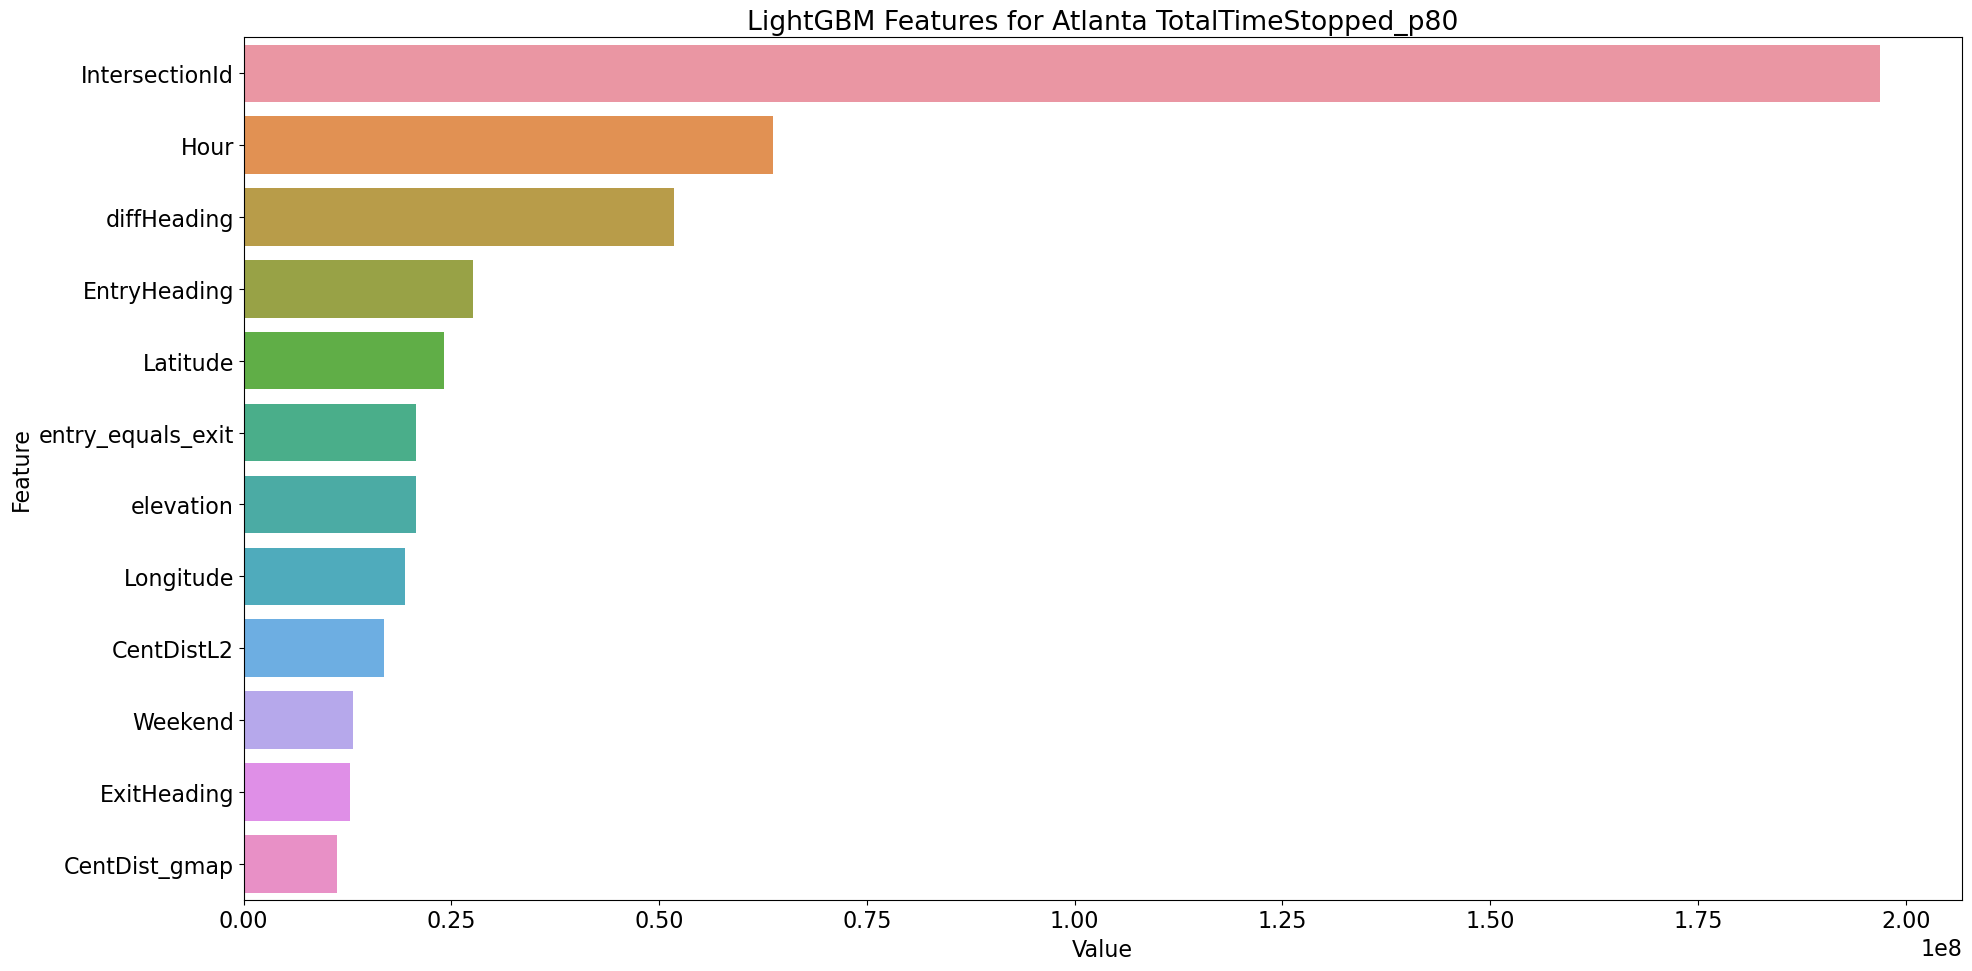

<Figure size 640x480 with 0 Axes>

In [35]:
feature_imp = pd.DataFrame(sorted(zip(models['Atlanta']['TotalTimeStopped_p80'].feature_importance(importance_type='gain'),city_testing_datasets_X['Atlanta'].columns)), columns=['Value','Feature'])
plt.rcParams.update({'font.size': 16})
plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[:-5])
plt.title('LightGBM Features for Atlanta TotalTimeStopped_p80')
plt.tight_layout()
# plt.xlim((0,10000))
plt.show()

plt.savefig('lgbm_importances-01.png')

In [36]:
models['Atlanta']['DistanceToFirstStop_p80'].num_trees()

167

In [63]:
with open('../data/models.pickle', 'wb') as handle:
    pickle.dump(models, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('../data/adv_models.pickle', 'wb') as handle:
    pickle.dump(adv_models, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [65]:
val_preds = []
val_labels = []
cnt = 1
for city in cities:
    # adverserial validation
    training = city_training_datasets_X[city].copy()
    training.drop(columns=['total_entries_exits'],inplace=True)
    testing = city_testing_datasets_X[city].copy()
    testing.drop(columns=['total_entries_exits'],inplace=True)
    training['target'] = 0
    testing['target'] = 1
    train_test = pd.concat([training, testing], axis = 0)
    target = train_test['target'].values
    train, test = train_test_split(train_test, test_size=0.33, random_state=42, shuffle=True)
    train_y = train['target'].values
    test_y = test['target'].values
    train = train.drop('target',axis=1)
    test = test.drop('target',axis=1)
    
    adv_models[city].fit(train,train_y)
    out = adv_models[city].predict_proba(test)[:,1]
    print(roc_auc_score(test_y,out))
    out_probs = adv_models[city].predict_proba(training.drop(columns=['target']).values)[:,0]
    val_size = int(0.3*len(city_training_datasets_X[city]))
    val_idxs = np.argsort(out_probs)[:val_size]
    train_idxs = np.argsort(out_probs)[val_size:]

    with open(f'../data/out_probs_{city}.pickle', 'wb') as handle:
        pickle.dump(out_probs, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    for target in rel_training_label_cols:
        print(f"City: {city}, Target: {target} ({cnt}/{len(cities)*len(rel_training_label_cols)})")
        
        X_train = city_training_datasets_X[city].iloc[train_idxs,:]
        y_train = city_training_datasets_y[city][target].values[train_idxs]
        X_validation = city_training_datasets_X[city].iloc[val_idxs,:]
        y_validation = city_training_datasets_y[city][target].values[val_idxs]
   
        vp = models[city][target].predict(X_validation)
        val_preds.append(vp)
        val_labels.append(y_validation)
        cnt += 1


with open(f'../data/val_preds.pickle', 'wb') as handle:
    pickle.dump(val_preds, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open(f'../data/val_labels.pickle', 'wb') as handle:
    pickle.dump(val_labels, handle, protocol=pickle.HIGHEST_PROTOCOL)
val_preds = np.concatenate(val_preds)
val_labels= np.concatenate(val_labels)

print(f"Val RMSE: {mean_squared_error(val_labels,val_preds,squared=False)}")

/home/gc28692/anaconda3/envs/hs/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/gc28692/anaconda3/envs/hs/lib/python3.9/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


0.6541168656206293
City: Atlanta, Target: TotalTimeStopped_p20 (1/24)
City: Atlanta, Target: TotalTimeStopped_p50 (2/24)
City: Atlanta, Target: TotalTimeStopped_p80 (3/24)
City: Atlanta, Target: DistanceToFirstStop_p20 (4/24)
City: Atlanta, Target: DistanceToFirstStop_p50 (5/24)
City: Atlanta, Target: DistanceToFirstStop_p80 (6/24)


/home/gc28692/anaconda3/envs/hs/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/gc28692/anaconda3/envs/hs/lib/python3.9/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


0.6553190768887445
City: Boston, Target: TotalTimeStopped_p20 (7/24)
City: Boston, Target: TotalTimeStopped_p50 (8/24)
City: Boston, Target: TotalTimeStopped_p80 (9/24)
City: Boston, Target: DistanceToFirstStop_p20 (10/24)
City: Boston, Target: DistanceToFirstStop_p50 (11/24)
City: Boston, Target: DistanceToFirstStop_p80 (12/24)
0.5577047271985873
City: Chicago, Target: TotalTimeStopped_p20 (13/24)
City: Chicago, Target: TotalTimeStopped_p50 (14/24)
City: Chicago, Target: TotalTimeStopped_p80 (15/24)
City: Chicago, Target: DistanceToFirstStop_p20 (16/24)
City: Chicago, Target: DistanceToFirstStop_p50 (17/24)
City: Chicago, Target: DistanceToFirstStop_p80 (18/24)


/home/gc28692/anaconda3/envs/hs/lib/python3.9/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/home/gc28692/anaconda3/envs/hs/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/gc28692/anaconda3/envs/hs/lib/python3.9/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


0.6530832987832308
City: Philadelphia, Target: TotalTimeStopped_p20 (19/24)
City: Philadelphia, Target: TotalTimeStopped_p50 (20/24)
City: Philadelphia, Target: TotalTimeStopped_p80 (21/24)
City: Philadelphia, Target: DistanceToFirstStop_p20 (22/24)
City: Philadelphia, Target: DistanceToFirstStop_p50 (23/24)
City: Philadelphia, Target: DistanceToFirstStop_p80 (24/24)
Val RMSE: 65.6905664011576
